In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from scipy.optimize import least_squares

# Nalaganje podatkov

Najprej naložimo višinske podatke skupaj s seznamov približnih centrov vrtač. Ker podatki niso podani na pravokotniku, imamo nekaj nan-ov. Te počistimo.

Tedaj dobimo nabor točk $(x_i, y_i)$ na celoštevilski mreži, podatek o višini v vsaki točki $h(x_i, y_i)$ in približke za centre $(x_i^c, y_i^c)$.

In [2]:
# Naložiš višinske podatke
holes = np.load('holes.npy')
# Počistiš nan-e
holes_min = np.nanmin(holes)
holes_n = np.nan_to_num(holes, holes_min)

# Naložimo približke za centre vrtač
centers = np.genfromtxt('centers.csv', delimiter=', ')
n = centers.shape[0]

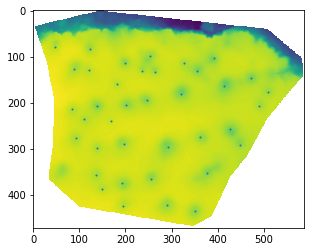

In [3]:
# Višinska karta skupaj z centri
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(holes)
ax.scatter(centers[:, 0], centers[:, 1], 1)

# Iskanje vrha vrtače

Iščemo vrh vrtače. S spremenljivko `sel` izberemo, katero vrtačo gledamo. Okoli vsakega centra izrežemo kvadrat velikosti `2*hole_window`. To bomo uporabili za fittanje krivulje.

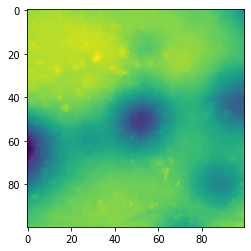

In [4]:
# Izberemo vrtačo št. 11
#
# Tu spremenimo, katero vrtačo gledamo
sel = 11

# Okoli vsakega centra izrežemo kvadrat velikosti 2*hole_window
hole_window = 50;

# Poskirbimo, da so koordinate celoštevilske
cx_e, cy_e = centers[sel, :]
cx_e = int(cx_e)
cy_e = int(cy_e)
hole = holes_n[cy_e-hole_window:cy_e+hole_window, cx_e-hole_window:cx_e+hole_window]

# Normaliziramo podatke, da bodo spodnje uteži delovale konsistentno
hole -= hole.min()
hole /= hole.max()

# Vektoriziramo matriko višin za potrebe poznejših računov
hole_f = hole.flatten()

plt.imshow(hole)

Postopek bo sledeči. Po nelinearni metodi najmanjših kvadratov fittamo neko krivuljo (npr. krog) na točke $(x, y)$, kjer je $h(x, y)$ utež.

Se pravi, npr. za krog minimiziramo
$$\sum_i h(x_i, y_i) \left[ (x_i - x_0)^2 + (y_i - y_0)^2 - R^2\right]^2 $$
po spremenjlivkah $(x_0, y_0)$, tj. center kroga in $R$, tj. polmer kroga.

To pa bi ustvarilo problem, saj bi postavilo krog pod pravi vrh. Zato vpeljemo drugačno utež, da močno penaliziramo točke, ki so pod vrhom. Tedaj je funkcija, ki jo optimiziramo, enaka
$$\sum_i w_h(h(x_i, y_i))^2 \left[(x_i - x_0)^2 + (y_i - y_0)^2 - R^2\right]^2, $$
kjer je $w_h$ definirana spodaj.

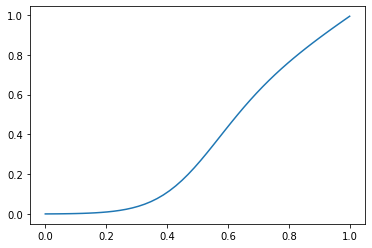

In [5]:
# Utež, ki je odvisna od višine
def h_w(h):
    return h/(1 + np.exp(-10*(h - 0.5)))

plt.plot(np.linspace(0, 1), h_w(np.linspace(0, 1)))

Se pravi fittamo krog na točke mreže s naslednjo utežjo

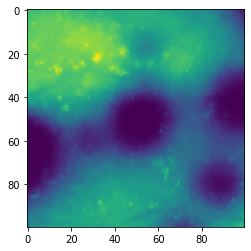

In [6]:
plt.imshow(h_w(hole)**2)

# Približki velikost lukenj

Naletimo na še en problem. Če bi iskali vrh vulkana, bi zgornji postopek deloval brez težav.
<p style="text-align:center;">
<img src="./img/vulkan.png" width="300"></img>
</p>
Problem je, da imamo vrtače, torej so luknje v zemlji in ne vrhovi. Razlika je v tem, da se ne spustijo nazaj navzdol, ko pridejo do vrha. To bi našemu algoritmu povzročalo zmedo, saj ne bi vedel, kam postaviti krog.
<p style="text-align:center;">
<img src="img/vrtaca.png" width="300"></img>
</p>
Zato rabimo še eno uzež, ki penalizira oddaljene točke. To bomo skonstruirali s pomočjo približne velikosti luknje. Naslednji korak bo torej izračunati približni polmer.

To bomo naredili tako, da bomo vzeli presek grafa $(x, y, h(x, y))$ s ravnino, paralelno $yz$-ravnini s $x$-koordinato približnega centra. Na ta presek fittamo logistično funkcijo in s pomočjo te se odločimo, kje je pribižno rob.

Spremenjlivka `cut_length` določa dolžino tega preseka v obe smeri od centra navzven. Ker sta na robu 'doline' dva 'hriba' razrežemo še to na pol, da dobimo dve krivulje, na kateri fittamo.

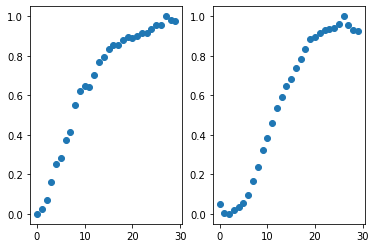

In [7]:
cut_length = 30;

# Vzamemo presek višin vzdolž x-osi, razdelimo na dva dela
height_left = np.flip(hole[hole_window, range(hole_window - cut_length, hole_window)])
height_right = hole[hole_window, range(hole_window, hole_window + cut_length)]

# Normaliziramo podatke
height_left -= height_left.min()
height_left /= height_left.max()

height_right -= height_right.min()
height_right /= height_right.max()

plt.subplot(1, 2, 1)
plt.scatter(range(cut_length), height_left)
plt.subplot(1, 2, 2)
plt.scatter(range(cut_length), height_right)

Sedaj fittamo logistično funkcijo na ti krivulji, se pravi minimiziramo
$$ \sum_j \left[ h(x_j, y^c) - \frac{1}{1 + e^{-c(x_j - x_0)}} \right]^2 $$
po $x_0$ in $c$.

Funkcija `scipy.optimize.least_squares` nam omogoča, da minimiziramo izraze oblike
$$ \sum_j \left[f(u_j;\,x)\right]^2 $$
po vektorju $x$. Za to rabimo podati funkcijo $f$, njeno Jacobijevko $Jf$ po $x$, nabor $u_j$ ter začetni približek za vektor parametrov $x_0$. Podamo lahko tudi dodatne parametre (Pri nas bosta vektorja višin `height_left` in `height_left` tako podana).
Funkcije so načeloma vektorizirane.
Izbira imen spremenljivk v funkcijah je v skladu z imeni v [scipy-jevi dokumentaciji](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html).

In [8]:
# Funkcija, ki jo želimo optimizirati
# Tukaj fittamo logistično funkcijo na zgornje višinske podatke
#
# x - x_0, c ... iskan vektor
# u - x-koordinate
# h - višine
def r_est_fun(x, u, h):
    return h - (1/(1 + np.exp(-x[1] * (u - x[0]))))   

In [9]:
# Jacobijeva matrika zgornje funkcije
def r_est_jac(x, u, h):
    (usx,) = u.shape;
    J = np.empty((usx, 2))
    J[:, 0] = (x[1] * np.exp(-x[1] * (u - x[0])))/(1+np.exp(-x[1] * (u - x[0])))**2
    J[:, 1] = -(u - x[0]) * np.exp(-x[1] * (u - x[0]))/(1 + np.exp(-x[1] * (u - x[0])))**2
    return J

In [10]:
# Fittamo krivuljo na presek vrtače
x0 = (int(hole_window/2), 1)
xs = np.array(range(cut_length))

res_l = least_squares(r_est_fun, x0, jac=r_est_jac, args=(xs, height_left), verbose=1)
res_r = least_squares(r_est_fun, x0, jac=r_est_jac, args=(xs, height_right), verbose=1)

`ftol` termination condition is satisfied.
Function evaluations 19, initial cost 5.5449e+00, final cost 3.7009e-02, first-order optimality 6.94e-06.
`ftol` termination condition is satisfied.
Function evaluations 17, initial cost 4.2495e+00, final cost 1.7458e-02, first-order optimality 5.16e-06.


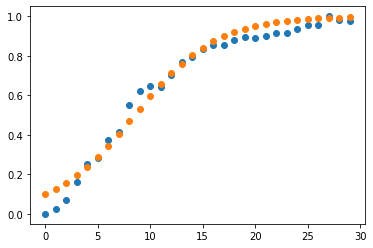

In [11]:
fig, ax = plt.subplots()
ax.scatter(xs, height_left)
(x_0, k) = res_l.x

fs = 1/(1 + np.exp(-k*(xs - x_0)))
ax.scatter(xs, fs)

Sedaj imamo logistično funkcijo. Odločiti se moramo le še, kje bo približno rob vrtače.
Naj bo $\ell(x)$ fittana logistična funkcija. Za približek polmera vzamemo takšno vrednost $x$, da je $\ell(x) = m$, za spodnji `m`.

In [12]:
# Funkcija, ki nam pretvori parametre za logistično funkcijo v približek za polmer.
def lower_boundary(rs, boundary):
    return - (1/rs.x[1])*np.log(1/boundary - 1) + rs.x[0]

# Vrednost boundary, ki jo bomo uporabljali.
m = 0.85

Nato izračunamo približek za zgornjo mejo luknje in vse to zapakiramo v gaussovo krivuljo.

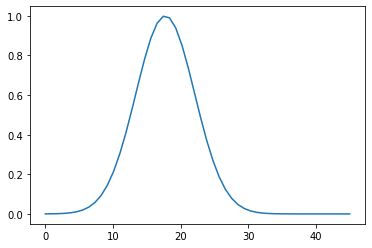

In [13]:
# Izračunamo spodnje meje
lb_left = lower_boundary(res_l, m)
lb_right = lower_boundary(res_r, m)
lb = min(lb_left, lb_right)

# Na podlagi razlike med spodnjo mejo in 'centrom' logistične funkcije določimo zgornjo mejo
ub = 2*lb - (res_l.x[0] + res_r.x[0])/2

# Na podlagi mej najdemo parametre za Gaussovo krivuljo
ex_val = (lb + ub)/2
sig2 = - ((lb - ex_val)**2)/(2*np.log(m))

# Definiramo utež, ki je odvisna od razdalje do centra
def dist_w(r):
    return np.exp(-((r - ex_val)**2)/(2*sig2))

plt.plot(np.linspace(0, 1.5*cut_length), dist_w(np.linspace(0, 1.5*cut_length)))

# Reševanje problema

Naj bo $w_d(r)$ zgornja utež. Da fitamo krivuljo na točlke s pomočjo uteži, minimiziramo vsoto
$$\sum_i w_d(||(x_i, y_i) - (x_0, y_0)||)^2 w_h(h(x_i, y_i))^2 F(x_i, y_i; \mathbf{p})^2, $$
kjer je $\mathbf p$ vektor parametrov - zgornjo vsoto minimiziramo po teh parametrih.

Za krog torej minimiziramo funkcijo
$$\sum_i w_d(||(x_i, y_i) - (x_0, y_0)||)^2 w_h(h(x_i, y_i))^2 \left[(x_i - x_0)^2 + (y_i - y_0)^2 - R^2\right]^2 $$
s enakim postopkom, kot pri računanju približka za polmer. Definiramo funkciji $f$ in $\text Jf$ ter začetni približek $\texttt{x0}$.

In [14]:
# x[0] = x_0, x[1] = x_1, x[2] = R
# u[0] = x_i, u[1] = y_i
def curve_implicit_eq(u, x):
    return (u[0, :] - x[0])**2 + (u[1, :] - x[1])**2 - x[2] ** 2

def d_curve_implicit_eq_0(u, x):
    return -2*(u[0, :] - x[0])

def d_curve_implicit_eq_1(u, x):
    return -2*(u[1, :] - x[1])

def d_curve_implicit_eq_3(u, x):
    return -2*x[2]



# Fittamo krog na rob tako, da optimiziramo naslednjo funkcijo.
# Ta je enaka:
#     višinska uzež * utež razdalje od centra * (x - x_0)² + (y - y_0)² - r²
# Argumenti:
# - x je iskan vektor, koordinate centra in polmer
# - u je vektor parametrov, pri nas x- in y-koordinati
# - h je vektor višin
def fun(x, u, h):
    height_weight = h_w(h)
    dists = u - x[0:1]
    dists = np.sqrt(dists[0, :]**2 + dists[1, :]**2)
    dist_weight = dist_w(dists)
    return height_weight*dist_weight*curve_implicit_eq(u, x)

# Jacobijeva matrika zgornje
def jac(x, u, h):
    (usx, usy) = u.shape;
    height_weight = h_w(h)
    dists = u - x[0:1]
    dists2 = dists[0, :]**2 + dists[1, :]**2
    dists = np.sqrt(dists2)
    dist_weight = dist_w(dists)
    J = np.empty((usy, 3))
    J[:, 0] = height_weight*curve_implicit_eq(u, x)*dist_weight*(2/sig2)*(dists - ex_val)*(u[0,:] - x[0])/(dists**2) +\
        dist_weight*height_weight*d_curve_implicit_eq_0(u, x)
    J[:, 1] = height_weight*curve_implicit_eq(u, x)*dist_weight*(2/sig2)*(dists - ex_val)*(u[1,:] - x[1])/(dists**2) +\
        dist_weight*height_weight*d_curve_implicit_eq_1(u, x)
    J[:, 2] = height_weight*dist_weight*d_curve_implicit_eq_2(u, x)
    return J;

# Začetni približek - moramo ga malce premakniti, da ne bo razdalja enaka nič.
# Izognemo se deljenju s nič.
nudge = 0.1
x0 = (hole_window+nudge, hole_window+nudge, hole_window/2)

Splošna elipsa je določena s implicitno formulo

$$ (a^2\sin(\theta)^2 + b^2\cos(\theta)^2) x^2 + 2(b^2 - a^2)\sin(\theta)\cos(\theta)xy + (a^2\cos(\theta)^2 + b^2\sin(\theta)^2)y^2 - (2Ax_0 + By_0)x - (Bx_0 + 2Cy_0)y + Ax_0^2 + Bx_0y_0 + Cy_0 - a^2b^2 = 0$$

In [15]:
# x[0] = x_0, x[1] = y_0, x[2] = a, x[3] = b, x[4] = \theta
# u[0, i] = x_i, u[1, i] = y_i

def curve_implicit_eq(u, x):
    A = (x[2]**2)*(np.sin(x[4])**2) + (x[3]**2)*(np.cos(x[4])**2)
    B = 2*(x[3]**2 - x[2]**2)*np.sin(x[4])*np.cos(x[4])
    C = (x[2]**2)*(np.cos(x[4])**2) + (x[3]**2)*(np.sin(x[4])**2)
    return A*u[0, :]**2 + B*u[0, :]*u[1, :] + C*u[1, :]**2 - (2*A*x[0] + B*x[1])*u[0, :] - (B*x[0] + 2*C*x[1])*u[1, :] + (A*x[0]**2 + B*x[0]*x[1] + C*x[1]**2 - x[2]*x[3])

def d_curve_implicit_eq(u, x, i):
    A = (x[2]**2)*(np.sin(x[4])**2) + (x[3]**2)*(np.cos(x[4])**2)
    B = 2*(x[3]**2 - x[2]**2)*np.sin(x[4])*np.cos(x[4])
    C = (x[2]**2)*(np.cos(x[4])**2) + (x[3]**2)*(np.sin(x[4])**2)
    match i:
        case 0:
            return -2*A*u[0, :] - B*u[1, :] + 2*A*x[0] + B*x[1]
        case 1:
            return -B*u[0, :] - 2*C*u[1, :] + B*x[0] + 2*C*x[1]
        case 2:
            dA = 2*x[2]*np.sin(x[4])**2
            dB = -4*x[2]*np.sin(x[4])*np.cos(x[4])
            dC = 2*x[2]*np.cos(x[4])**2
            return dA*u[0, :]**2 + dB*u[0, :]*u[1, :] + dC*u[1, :]**2 - (2*dA*x[0] + dB*x[1])*u[0, :] - (dB*x[0] - 2*dC*x[1])*u[1, :] + (dA*x[0]**2 + dB*x[0]*x[1] + dC*x[1]**2 - 2*x[2]*x[3]**2)
        case 3:
            dA = 2*x[3]*np.cos(x[4])**2
            dB = 4*x[3]*np.sin(x[4])*np.cos(x[4])
            dC = 2*x[3]*np.sin(x[4])**2
            return dA*u[0, :]**2 + dB*u[0, :]*u[1, :] + dC*u[1, :]**2 - (2*dA*x[0] + dB*x[1])*u[0, :] - (dB*x[0] - 2*dC*x[1])*u[1, :] + (dA*x[0]**2 + dB*x[0]*x[1] + dC*x[1]**2 - 2*x[3]*x[2]**2)
        #etc

Parametrična krivulja
$$ r = a_0 + a_1\cos(\theta)^2 + b_1\sin(\theta)^2 + a_2\cos(2\theta)^2 + b_2\sin(2\theta)^2 $$
kjer je $r = || (x-x_0, y-y_0) ||$ in $\theta = \text{atan2}(y-y_0, x-x_0)$. Implicitna enačba je torej
$$ || (x-x_0, y-y_0) || - a_0 - a_1\cos(\text{atan2}(y-y_0, x-x_0))^2 - b_1\sin(\text{atan2}(y-y_0, x-x_0))^2 - a_2\cos(2\text{atan2}(y-y_0, x-x_0))^2 - b_2\sin(2\text{atan2}(y-y_0, x-x_0))^2 = 0 $$
\# TODO: poenostavi $\sin(\text{atan2})$ etc

In [16]:
# x[0] = x_0, x[1] = y_0, x[2] = a_0, x[3] = a_1, x[4] = b_1, x[5] = a_2, x[6] = b_2
# u[0, i] = x_i, u[1, i] = y_i

def curve_implicit_eq(u, x):
    u_m_x0 = (u.T - x[0:2]).T
    r = np.linalg.norm(u_m_x0, axis=0)
    theta = np.arctan2(u_m_x0[1], u_m_x0[0])
    return r - x[2] - x[3]*np.cos(theta)**2 - x[4]*np.sin(theta)**2 - x[5]*np.cos(2*theta)**2 - x[6]*np.sin(2*theta)**2

def d_curve_implicit_eq(u, x, i):
    u_m_x0 = (u.T - x[0:2]).T
    r = np.linalg.norm(u_m_x0, axis=0)
    theta = np.arctan2(u_m_x0[1], u_m_x0[0])
    match i:
        case 0: # d/dx_0
            r_x0 = -u_m_x0[0]/r
            theta_x0 = (u_m_x0[1]/(u_m_x0[0]**2))/(np.cos(u_m_x0[1]/u_m_x0[0])**2)
            return r_x0 - x[3]*(-1)*2*np.cos(theta)*np.sin(theta)*theta_x0 - x[4]*2*np.sin(theta)*np.cos(theta)*theta_x0 - x[5]*(-2)*np.cos(2*theta)* np.sin(2*theta)*2*theta_x0 - x[6]*2*np.sin(2*theta)*np.cos(2*theta)*2*theta_x0
        case 1: # d/dy_0 
            r_y0 = -u_m_x0[1]/r
            theta_y0 = -1/((np.cos(u_m_x0[1]/u_m_x0[0])**2)*u_m_x0[0])
            return r_y0 - x[3]*(-1)*2*np.cos(theta)*np.sin(theta)*theta_y0 - x[4]*2*np.sin(theta)*np.cos(theta)*theta_y0 - x[5]*(-2)*np.cos(2*theta)* np.sin(2*theta)*2*theta_y0 - x[6]*2*np.sin(2*theta)*np.cos(2*theta)*2*theta_y0
        case 2: # d/da_0
            return -1
        case 3: # d/da_1
            return -np.cos(theta)**2
        case 4: # d/db_1
            return -np.sin(theta)**2
        case 5: # d/da_2
            return -np.cos(2*theta)**2
        case 6: # d/db_2
            return -np.sin(2*theta)**2



def fun(x, u, h):
    height_weight = h_w(h)
    dists = (u.T - x[0:2]).T
    dists = np.sqrt(dists[0, :]**2 + dists[1, :]**2)
    dist_weight = dist_w(dists)
    return height_weight*dist_weight*curve_implicit_eq(u, x)

def jac(x, u, h):
    (usx, usy) = u.shape;
    height_weight = h_w(h)
    dists = (u.T - x[0:2]).T
    dists2 = dists[0, :]**2 + dists[1, :]**2
    dists = np.sqrt(dists2)
    dist_weight = dist_w(dists)
    
    n_vars = 7
    center_vars = 2
    J = np.empty((usy, n_vars))
    for i in range(n_vars):
        if i < center_vars:
            J[:, i] = height_weight*curve_implicit_eq(u, x)*dist_weight*(2/sig2)*(dists - ex_val)*(u[0,:] - x[0])/(dists**2) +\
                dist_weight*height_weight*d_curve_implicit_eq(u, x, i)
        else:
            J[:, i] = dist_weight*height_weight*d_curve_implicit_eq(u, x, i)
    return J

nudge = 0.1
x0 = (hole_window+nudge, hole_window+nudge, hole_window/2, 1, 1, 1, 1)

Sestavimo vektor $\texttt{u}$; pri nas bo $\texttt{u[0, i]} = x_i$ in $\texttt{u[1, i]} = y_i$.

In [17]:
# Naredimo 2*n array koordinat.
# Ta bo argument 'u' v fun
pos_x = np.tile(range(2*hole_window), [2*hole_window, 1]).reshape((1, 4*hole_window**2))
pos_y = np.tile(np.reshape(range(2*hole_window), (2*hole_window, 1)), (1, 2*hole_window)).reshape((1, 4*hole_window**2))
pos = np.concatenate((pos_x, pos_y), axis=0) # u

In [18]:
# Fittamo
res = least_squares(fun, x0, jac=jac, args=(pos, hole_f), verbose=1)
fitted_params = res.x
print(fitted_params)

`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 8.9211e+03, final cost 1.0063e+03, first-order optimality 3.09e+07.
[  50.24960331   50.16259406   71.62049516   73.59908023   73.7593785
 -126.24268552 -126.08722116]


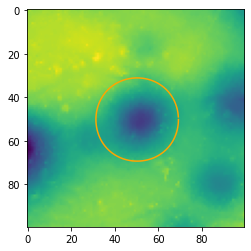

In [20]:
# Risanje parametrične krivulje

x_0 = fitted_params[0]
y_0 = fitted_params[1]
a_0 = fitted_params[2]
a_1 = fitted_params[3]
b_1 = fitted_params[4]
a_2 = fitted_params[5]
b_2 = fitted_params[6]

n_pts = 100
ts = np.linspace(0, 2*np.pi, num = n_pts + 1)
ts = ts[0:-1]
#rs = np.empty((n_pts, ))
rs = a_0 + a_1*np.cos(ts)**2 + b_1*np.sin(ts)**2 + a_2*np.cos(2*ts)**2 + b_2*np.sin(2*ts)**2
pts = np.array([rs*np.cos(ts), rs*np.sin(ts)])
pts = (pts.T + [x_0, y_0]).T

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.imshow(hole)
ax.plot(pts[0], pts[1], color='orange')

Površina območja, ki ga krivulja omejuje, je
$$ A = \frac 1 2 \int_0^{2\pi} r^2 \text{d}\theta = \frac{{\pi}\cdot\left(3b_2^2+\left(4b_1+2a_2+4a_1+8a_0\right)b_2+3b_1^2+\left(4a_2+2a_1+8a_0\right)b_1+3a_2^2+\left(4a_1+8a_0\right)a_2+3a_1^2+8a_0a_1+8a_0^2\right)}{8}. $$
Hvala dragemu bogu za [to stvar](https://www.integral-calculator.com/).

In [21]:
Area = (np.pi/8)*(3*b_2**2 + (4*b_1 + 2*a_2 + 4*a_1 + 8*a_0)*b_2 + 3*b_1**2 + (4*a_2 + 2*a_1 + 8*a_0)*b_1 + 3*a_2**2 + (4*a_1 + 8*a_0)*a_2 + 3*a_1**2 + 8*a_0*a_1 + 8*a_0**2)
print(Area)

1150.2806455493253


Dolžina krivulje je
$$ L = \int_0^{2\pi}\sqrt{r^2 + (r')^2} \text{d}\theta $$
Glej HTML komentar za formulo enačbe. Tista stran odpove, nimam delujoče matlab licence.
<!---
sqrt((a_0 + a_1*cos(t)^2 + b_1*sin(t)^2 + a_2*cos(2t)^2 + b_2*sin(2t)^2)^2 + (-2a_1 cos(t)sin(t) + 2b_1 sin(t) cos(t)-4a_2 cos(2t)sin(2t) + tb_2 sin(2t)cos(2t))^2)
-->